In [27]:
import os, sys
import numpy
import subprocess
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
plt.rcParams.update({'font.size': 10})

# Reading and exploring raw files

In [79]:
# Setting path and filenames
path = '/home/mia/Documents/work_UA/Data/test/raw/'
file = 'P13401010092bttagfraw.fit'

In [80]:
# Reading the file
hdul = fits.open(path+file)
hdul.info()

Filename: /home/mia/Documents/work_UA/Data/test/raw/P13401010092bttagfraw.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  EVENTS        1 BinTableHDU     40   47300R x 4C   [1E, 1I, 1I, 1B]   
  2  GTI           1 BinTableHDU     22   1R x 2C   [1D, 1D]   


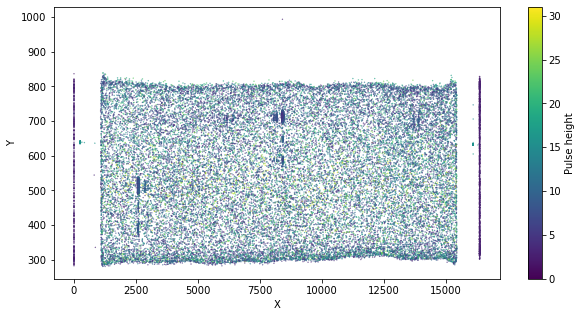

In [81]:
# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['X'], dat['Y'], s=0.1, c=dat['PHA'])
cbar = plt.colorbar(plot)
cbar.set_label('Pulse height')
ax.set_ylabel('Y')
ax.set_xlabel('X')
plt.show()

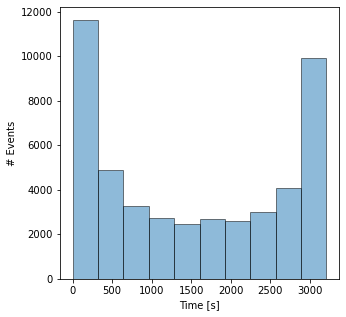

In [82]:
# Plotting histogram of photon events as a function of time

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.hist(dat['Time'], edgecolor='black', alpha=0.5)
ax.set_xlabel('Time [s]')
ax.set_ylabel('# Events')
plt.show()

In [83]:
hdul.close()

# Generating intermediate files

The routine transforms the raw data into an intermediate data file (IDF): copy X, Y, arrival time, puls height of each photon event; initialization of weight. Photon events outside of the detector active region are flagged. Two more extensions: good time intervals (directly copies from raw file), and timeline table containing 16 arrays with status flags, spacecraft position, detector high-voltage, countrate parameters, listed once per second. 

In [84]:
# Running the FUSE initialization routine
os.system('rm test_IDF_ttag.fit')
process_str = 'cf_ttag_init '+path+file+' test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

   cf_ttag_init-1.42: This is CalFUSE v3.2.3
   cf_timeline-1.41: No housekeeping file: filling timeline with header info.
2022 Jun 20 17:41:56 cf_ttag_init-1.42: Finished processing


CompletedProcess(args='cf_ttag_init /home/mia/Documents/work_UA/Data/test/raw/P13401010092bttagfraw.fit test_IDF_ttag.fit', returncode=0)

In [85]:
# Reading the file
hdul = fits.open('test_IDF_ttag.fit')
hdul.info()

Filename: test_IDF_ttag.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     366   ()      
  1  TTAG DATA     1 BinTableHDU     59   1R x 14C   [47300E, 47300I, 47300I, 47300B, 47300E, 47300I, 47300I, 47300I, 47300I, 47300B, 47300B, 47300B, 47300E, 47300E]   
  2  GTI           1 BinTableHDU     21   1R x 2C   [1D, 1D]   
  3  TIMELINE      1 BinTableHDU     73   1R x 16C   [3208E, 3208B, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I, 3208I]   


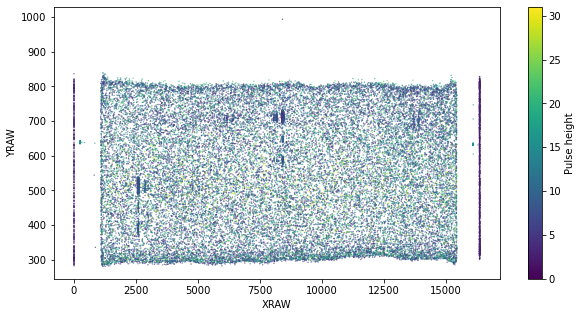

In [86]:
# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['XRAW'], dat['YRAW'], s=0.1, c=dat['PHA'])
cbar = plt.colorbar(plot)
cbar.set_label('Pulse height')
ax.set_ylabel('YRAW')
ax.set_xlabel('XRAW')
plt.show()

# The event distribution on the detector looks the same as in the raw 
# data file, as expected. 

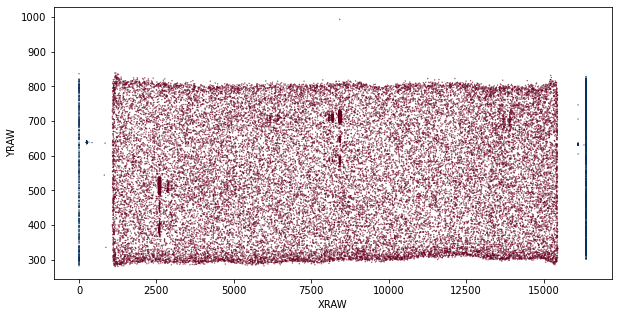

In [87]:

# Plotting all photon events on the XY plane
dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(10,5))
plot = ax.scatter(dat['XRAW'], dat['YRAW'], s=0.1, c=dat['LOC_FLGS'], 
                 cmap='RdBu')
ax.set_ylabel('YRAW')
ax.set_xlabel('XRAW')
plt.show()

# The blue events are flagged as they occurr outside of the detector 
# active region. 

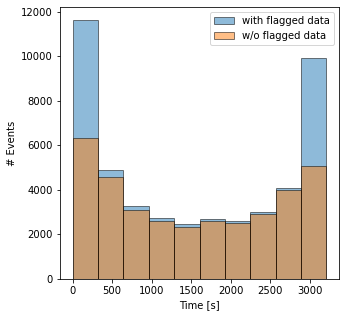

In [88]:
# Plotting histogram of photon events as a function of time
# one histogram including all data
# and another one excluding the data outside the activeregion

dat = hdul[1].data

fig, ax = plt.subplots(1,1, figsize=(5,5))

time = np.array(np.concatenate(dat['Time']).flat)
loc_flgs = np.array(np.concatenate(dat['LOC_FLGS']).flat, dtype=bool)
loc_flgs = np.invert(loc_flgs)

ax.hist(time, edgecolor='black', alpha=0.5, label='with flagged data')
ax.hist(time[loc_flgs>0], edgecolor='black', alpha=0.5, label='w/o flagged data')
ax.set_xlabel('Time [s]')
ax.set_ylabel('# Events')
ax.legend()
plt.show()

# The photon events outside the active region mostly occurred at the 
# very beginning and and of the exposure.

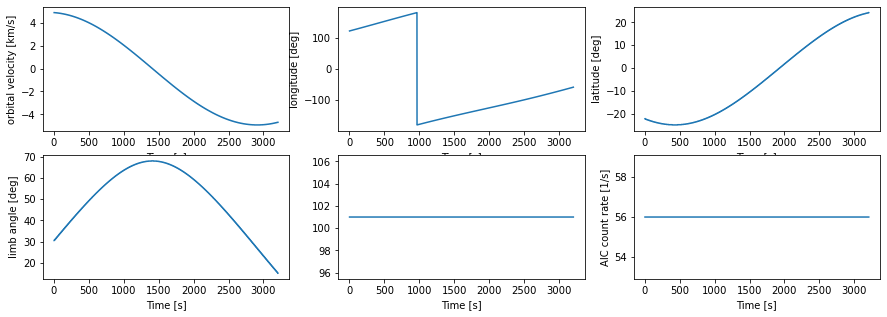

In [89]:
# plotting a few parameters from the third extennsion

# reading from file
dat = hdul[3].data
time = np.array(np.concatenate(dat['TIME']).flat)
orbital_vel = np.array(np.concatenate(dat['ORBITAL_VEL']).flat)
long = np.array(np.concatenate(dat['LONGITUDE']).flat)
lat = np.array(np.concatenate(dat['LATITUDE']).flat)
limb = np.array(np.concatenate(dat['LIMB_ANGLE']).flat)
volt = np.array(np.concatenate(dat['HIGH_VOLTAGE']).flat)
aic = np.array(np.concatenate(dat['AIC_CNT_RATE']).flat)

# generating the plot
fig, ax = plt.subplots(2, 3, figsize=(15,5))
ax[0,0].plot(time, orbital_vel)
ax[0,0].set_ylabel('orbital velocity [km/s]')
ax[0,1].plot(time, long)
ax[0,1].set_ylabel('longitude [deg]')
ax[0,2].plot(time, lat)
ax[0,2].set_ylabel('latitude [deg]')
ax[1,0].plot(time, limb)
ax[1,0].set_ylabel('limb angle [deg]')
ax[1,1].plot(time, volt)
ax[1,1].set_label('high voltage')
ax[1,2].plot(time, aic)
ax[1,2].set_ylabel('AIC count rate [1/s]')
[axx.set_xlabel('Time [s]') for axx in ax.flat]
plt.show()

In [90]:
hdul.close()

# Conversion to FARF

This module removes detector artifacts (dead time and positional inaccuracies) and consists of the subroutines cf_check_digitizer, cf_electronics_dead_time, cf_ids_dead_time, cf_fifo_dead_time, cf_apply_deadtime

## Digitizer keyword

Compares 16 values stored in file header keywords reporting on detector settings with values in calibration file 'DIGI_CAL'. When significant differences are present, warnings are written into the header and trailer files and the header keyword EXP_STAT is in that case set to -2. 

In [91]:
# Checking header keyword EXP_STAT before running the subroutine
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[0].header['EXP_STAT'])
hdul.close()

0


In [92]:
# Running the FUSE initialization routine
process_str = 'cf_convert_to_farf -eiftrsgpa test_IDF_ttag.fit'
subprocess.run(process_str, shell=True)

2022 Jun 20 17:42:18 cf_convert_to_farf-1.22: Finished processing


CompletedProcess(args='cf_convert_to_farf -eiftrsgpa test_IDF_ttag.fit', returncode=0)

In [93]:
# Checking header keyword EXP_STAT after running the subroutine
hdul = fits.open('test_IDF_ttag.fit')
print(hdul[0].header['EXP_STAT'])
hdul.close()

# No discrepancies occurred, as expected. 

0


## Correct for detector dead time

### Correct for electronics dead time

In [107]:
hdul = fits.open('test_IDF_ttag.fit')
dat = hdul[3].data['TIME']
hdul.close()

In [76]:
hdul[3].columns

ColDefs(
    name = 'TIME'; format = '1147E'; unit = 'seconds'
    name = 'STATUS_FLAGS'; format = '1147B'; unit = 'unitless'
    name = 'TIME_SUNRISE'; format = '1147I'; unit = 'seconds'
    name = 'TIME_SUNSET'; format = '1147I'; unit = 'seconds'
    name = 'LIMB_ANGLE'; format = '1147I'; unit = 'degrees'; bscale = 0.1; bzero = 0.0
    name = 'LONGITUDE'; format = '1147I'; unit = 'degrees'; bscale = 0.1; bzero = 0.0
    name = 'LATITUDE'; format = '1147I'; unit = 'degrees'; bscale = 0.1; bzero = 0.0
    name = 'ORBITAL_VEL'; format = '1147I'; unit = 'km/s'; bscale = 0.01; bzero = 0.0
    name = 'HIGH_VOLTAGE'; format = '1147I'; unit = 'unitless'
    name = 'LIF_CNT_RATE'; format = '1147I'; unit = 'counts/sec'
    name = 'SIC_CNT_RATE'; format = '1147I'; unit = 'counts/sec'
    name = 'FEC_CNT_RATE'; format = '1147I'; unit = 'counts/sec'; bscale = 1.0; bzero = 32768.0
    name = 'AIC_CNT_RATE'; format = '1147I'; unit = 'counts/sec'; bscale = 2.0; bzero = 65536.0
    name = 'BKGD_CNT_R

In [111]:
test = fits.getdata('test_IDF_ttag.fit',3)

In [129]:
arr = test['FEC_CNT_RATE'] +1.

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint16') with casting rule 'same_kind'

In [127]:
arr

array([[1., 1., 1., ..., 1., 1., 1.]])